### dev paincontrol

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

In [3]:
from compare_paincontrol import fit_bp, make_data_paincontrol
from compare_hyperparams import load_feats, feature_importance, load_modZ, load_cv
from compare_bfl_qsidp import load_qscode, match_question

/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [4]:
import nilearn
print(nilearn.__version__)

0.8.1


In [5]:
import nibabel
print(nibabel.__version__)

3.2.1


#### load output

In [6]:
curr_dir = '/well/seymour/users/uhu195/python/extract_npy'
cv_dir = os.path.join(curr_dir, 'cv_results', 'paincontrol')

In [7]:
df = load_cv(cv_dir).reset_index()

   max_depth  n_estimators  max_features  min_samples_split  min_samples_leaf  \
0         10           250      0.820720                 11                 1   
1         17           200      0.697955                  7                12   
2          7           100      0.402140                 14                12   
3          3           150      0.900529                  8                 3   
4         30           200      0.241131                  5                 7   

   max_samples  balanced_accuracy   roc_auc  bestIC               qsidp  
0     0.707573           0.521071  0.534301     500                None  
1     0.624759           0.516023  0.519340     500          ['t1vols']  
2     0.922302           0.526557  0.535059     500  ['subcorticalvol']  
3     0.892806           0.519735  0.529716     500            ['fast']  
4     0.866528           0.531596  0.540265     500          ['t2star']  


In [8]:
df.shape

(560, 11)

In [9]:
df.iloc[df['balanced_accuracy'].argmax()]

index                                                  13
max_depth                                               6
n_estimators                                           75
max_features                                     0.583464
min_samples_split                                       6
min_samples_leaf                                       11
max_samples                                        0.9744
balanced_accuracy                                0.640243
roc_auc                                           0.67545
bestIC                                                100
qsidp                ['cognitive', 'lifestyle', 'mental']
Name: 493, dtype: object

In [10]:
def print_clf_table(df, n=3):
    """print classifier performance top n"""
    df_show = df.iloc[df['balanced_accuracy'].sort_values(ascending=False).index[:n]][['qsidp','bestIC','balanced_accuracy','roc_auc']]
    df_show['qsidp'] = df_show.qsidp.str.replace(']', '', regex=False)
    df_show['qsidp'] = df_show.qsidp.str.replace('[', '', regex=False)
    df_show.rename(columns={'qsidp': 'Feature items', 
                            'bestIC': 'Imaging components', 
                            'balanced_accuracy': 'Balanced accuracy',
                           'roc_auc': 'ROC AUC'}, inplace=True)
    print(df_show.to_latex(index=False, float_format="{:0.3f}".format))

In [11]:
print_clf_table(df, n=3)

\begin{tabular}{lrrr}
\toprule
                     Feature items &  Imaging components &  Balanced accuracy &  ROC AUC \\
\midrule
'cognitive', 'lifestyle', 'mental' &                 100 &              0.640 &    0.675 \\
              'taskfmri', 'mental' &                 100 &              0.639 &    0.674 \\
'cognitive', 'lifestyle', 'mental' &                  50 &              0.639 &    0.674 \\
\bottomrule
\end{tabular}



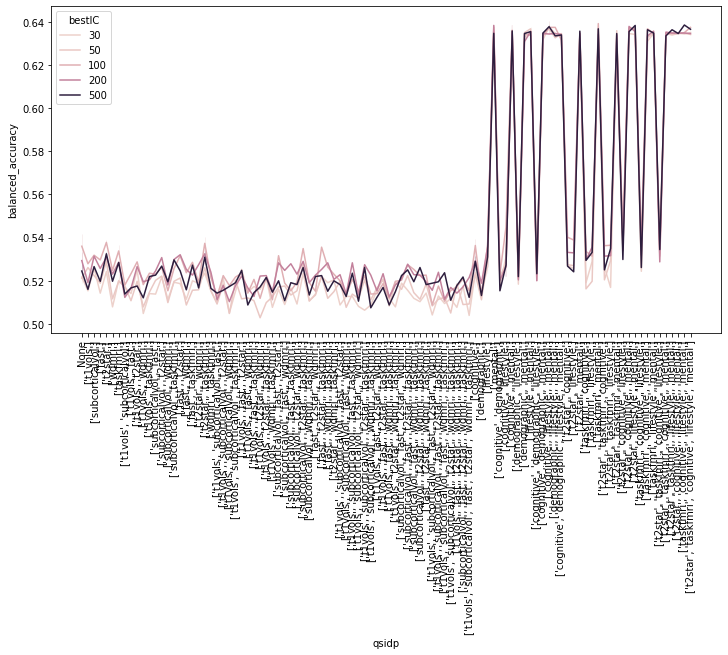

In [27]:
df_sorted = df.iloc[df['balanced_accuracy'].sort_values().index[-100:]]
fig, ax = plt.subplots(figsize=(12, 6))
_ = sns.lineplot(data=df, x='qsidp', y='balanced_accuracy', hue='bestIC', ax=ax)
# _ = sns.lineplot(data=df_sorted, x='qsidp', y='balanced_accuracy', hue='bestIC', ax=ax)
_ = plt.xticks(rotation=90)

#### check importance

In [12]:
bestIC = 100
qs_ls = ['cognitive', 'lifestyle', 'mental']
# qs_ls = ['cognitive', 'lifestyle']
idp_ls = None

In [13]:
bp = df.iloc[df['balanced_accuracy'].argmax()].to_dict()

In [14]:
for i in ['balanced_accuracy', 'roc_auc', 'bestIC', 'qsidp', 'index']:
    del bp[i]

In [15]:
bp

{'max_depth': 6,
 'n_estimators': 75,
 'max_features': 0.5834635143300102,
 'min_samples_split': 6,
 'min_samples_leaf': 11,
 'max_samples': 0.9744003086057368}

In [17]:
# load bfl
df_bfl_qsidp = make_data_paincontrol(bestIC=bestIC, qs_ls=qs_ls, idp_ls=idp_ls)
# retrain params
X_train, y_train, X_valid, y_valid = load_feats(df_bfl_qsidp, test_size=0.25, dummies=False,
                              train=True, balance=True, scaler=True)

/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (863,867) have mixed types.Specify dtype option on import or set low_memory=False.
  


df_qs_imputed_dum shape=(4558, 270)
df_bfl_qsidp shape=(4558, 372)
(4558, 369)


In [18]:
df_bfl_qsidp.shape

(4558, 372)

In [19]:
df_bfl_qsidp['label'].value_counts()

1    2280
0    2278
Name: label, dtype: int64

In [98]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(**bp, random_state=3)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_features=0.5834635143300102,
                       max_samples=0.9744003086057368, min_samples_leaf=11,
                       min_samples_split=6, n_estimators=75, random_state=3)

In [99]:
preds = clf.predict(X_train)
print(len(preds))
print(balanced_accuracy_score(y_train, preds))
print(sum(y_train==preds)/len(y_train))

3417
0.7228414661051905
0.7228563067017852


In [100]:
roc_auc_score(y_valid, clf.predict_proba(X_valid)[:,1])

0.6722720685721333

In [101]:
output_ls = ['label', 'eid', 'bmrc']
tmp = df_bfl_qsidp.drop(columns=output_ls)
feature_names = tmp.columns

In [102]:
feat_importances = pd.Series(clf.feature_importances_, index=feature_names)

In [103]:
feat_sorted = feat_importances.sort_values(ascending=False)

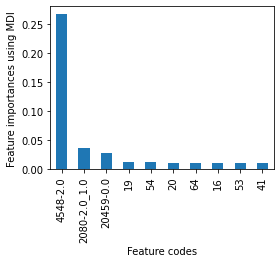

In [128]:
fig, ax = plt.subplots(figsize=(4,3))
feat_sorted.iloc[:10].plot.bar(ax=ax)
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
ax.set_ylabel('Feature importances using MDI')
ax.set_xlabel('Feature codes')
plt.savefig('figs/paincontrol_featureimportance.png', bbox_inches='tight', dpi=200)

In [105]:
feats10 = feat_sorted.iloc[:10].index
match_question(feats10)

[array(['Health satisfaction'], dtype=object),
 array(['Frequency of tiredness / lethargy in last 2 weeks'], dtype=object),
 array(['General happiness with own health'], dtype=object)]

#### visualising top feature

In [106]:
data_dir = '/well/tracey/shared/fps-ukb/bigflica_output/output_paincontrol_500/Result_IC100/'

In [107]:
def top_mods(data_dir, top_feat, mod_num=3, plot=True):
    """return top modalities given feature importance"""
    mod_contrib = np.load(os.path.join(data_dir, 'mod_contribution.npy')) # mod x feats
#     top_feat = int(feature_importance.index[0].split(' ')[1])
    print(f'top feature: {top_feat}')
    topIC = mod_contrib[:,top_feat]
    sorted_idx = topIC.argsort()[::-1]
    # load mod names
    mod_names = pd.read_csv('./sorted_feats.csv')
    plot_mod = mod_names.iloc[sorted_idx]
    if plot:
        plotIC = topIC[sorted_idx[:mod_num]]
        plot_mod_names = plot_mod['modalities'].iloc[:mod_num]
        import matplotlib.pyplot as plt
        plt.subplots(figsize=(4,3))
        plt.bar(np.arange(len(plotIC)), plotIC)
        plt.xticks(np.arange(len(plot_mod_names)), plot_mod_names, rotation=90)
        plt.xlabel('Imaging modality')
        plt.ylabel('Modality contribution')
    return top_feat, sorted_idx

top feature: 19


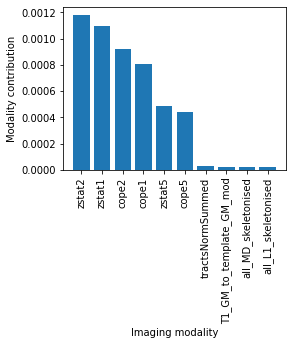

In [108]:
top_feat, mod_ls = top_mods(data_dir, top_feat=19, mod_num=10)
plt.savefig('figs/paincontrol_contribution.png', bbox_inches='tight', dpi=200)

In [109]:
mod_ls

array([40,  8, 34, 44, 43, 37, 27,  9, 28, 22, 36, 12, 11,  3, 29,  6, 14,
       26,  5, 25, 15, 24, 32, 21,  2, 39,  1, 20, 19, 31, 17,  4, 41, 16,
        0, 23, 38, 33, 18, 35, 42, 10,  7, 30, 13])

In [110]:
top_feat

19

In [126]:
def load_modZ_multi(data_dir, modality_ls, feature_num, plot_threshold, plot_num=4,
              plot_coords=[0, 0, 0], plot=True, save_plot=True, save_name='paincontrol_blf.png',
              curr_dir='/well/seymour/users/uhu195/python/extract_npy'):
    """load modality Z map given number"""
    import nibabel as nib
    from nibabel import Nifti1Image
    from nilearn.plotting import plot_stat_map
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(plot_num, 1, figsize=(10, 3*plot_num))
    for n, modality_num in enumerate(modality_ls[:plot_num]):
        df_mod = np.load(os.path.join(data_dir, f'flica_mod{modality_num+1}_Z.npy'))
        print(df_mod.shape)
        img_data = df_mod[:,feature_num]
        # load mask by shape
        if df_mod.shape[0]>1e6:
            mask_path = os.path.join(curr_dir, 'MNI152_T1_1mm_brain.nii.gz')
        else:
            mask_path = os.path.join(curr_dir, 'MNI152_T1_2mm_brain.nii.gz')
        mask_img = nib.load(mask_path)
        mask_data = mask_img.get_fdata()
        mask = np.where(mask_data>0)
        # reshape z map
        img_reshape = np.zeros(mask_data.shape)
        img_reshape[mask] = img_data
        # reconstruct using MNI affine
        img_reshape_ni = Nifti1Image(img_reshape, affine=mask_img.affine)
        # load modality names
        mod_names = pd.read_csv(os.path.join(curr_dir, 'sorted_feats.csv'))
        # plotting
        if plot:
            ax = plt.subplot(plot_num, 1, n+1)
            plot_mod = mod_names.iloc[modality_num].values
            plot_stat_map(img_reshape_ni, bg_img=mask_path, threshold=plot_threshold, 
                          cut_coords=plot_coords, title=plot_mod[0], axes=ax)
        if save_plot:
            plt.savefig(os.path.join(curr_dir, 'figs', save_name), bbox_inches='tight', dpi=200)


(228453, 100)
(228453, 100)
(228453, 100)
(228453, 100)


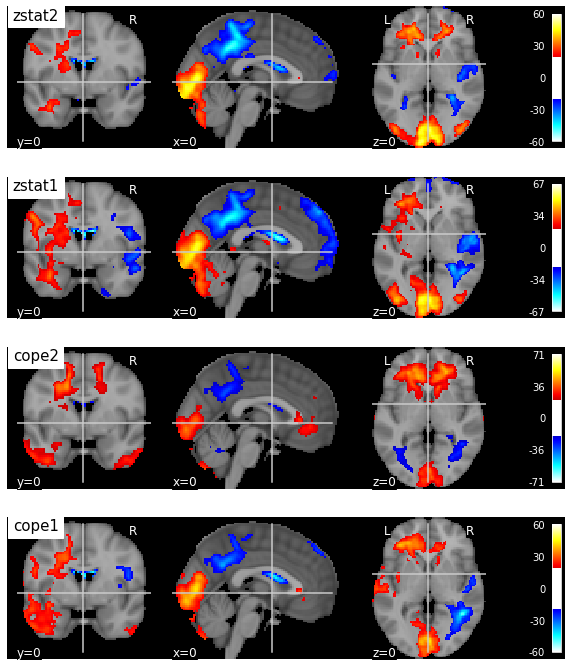

In [129]:
load_modZ_multi(data_dir, modality_ls=mod_ls, feature_num=top_feat, plot_threshold=20)